<a href="https://colab.research.google.com/github/LazaroR-u/EQNN/blob/main/REFLECTION_EQNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## REFLECTION EQUIVARIANT QUANTUM NEURAL NETWORK

In this notebook, we build the invariant Reflection Equivariant Quantum Neural Network, consisting of the reflection over the X and Y axis.

We test the invariance of this model using the MNIST dataset.

The main reference is:

Reflection Equivariant Quantum Neural Networks for Enhanced Image Classification
https://arxiv.org/abs/2212.00264

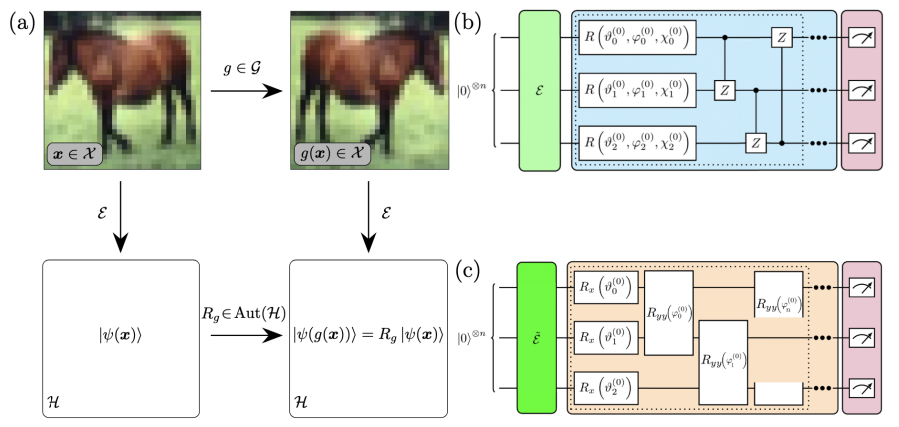

## Motivation
In the last years, we have witnessed exponential development and applications of quantum machine learning. These models are usually fully quantum or hybrid quantum-classical. However, most of them do not present a real advantage over classical machine learning techniques. Some promising models that work on NISQ devices and require low resources to achieve equal or better results compared to classical machine learning include the Data-Reuploading model and the recently introduced Equivariant Quantum Neural Networks (EQNNs).


EQNNs consist of a typical QNN that considers the symmetry of the data. This knowledge allows for the construction of an appropriate ansatz that is equivariant under the symmetry operation. By incorporating data symmetry, we can build QNNs that reduce the number of possible configurations of the model, thereby narrowing the parameter space. This approach enhances learning with less data and improves generalization.

We choose reflection symmetry because it is widely present in image datasets, which are highly used in fields such as high-energy physics.


## Introduction to Reflection Equivariant Quantum Neural Network

This quantum neural network (QNN) model is designed to maintain equivariance under reflections. The core architecture of the model consists of two main quantum gates:

1. **Equivariant Amplitude Embedding**: This technique encodes input features into the quantum state.
2. **IsingYY**: We apply IsingYY gates to each pair of qubits using the same parameters, ensuring equivariance in the model. These trainable layers can be applied multiple times (n_layers).

To ensure equivariance in the model, we apply layers of IsingYY gates with the same parameters across all qubits. These trainable layers can be stacked n_layers times.

The output of the model is the expectation value of the product of all qubits with respect to the Pauli Z observable.

### Dataset and Preprocessing

We use the MNIST dataset and apply a series of transformations and preprocessing steps. A key transformation is the reflection over the X-axis, which allows us to evaluate the model's ability to handle symmetries in the data.

### Training the Model

We use JAX and Optax for training due to their fast training capabilities and easy integration with PennyLane. These tools allow us to implement and optimize the QNN effectively, leveraging hardware acceleration.


In [6]:
%%capture
pip install pennylane jax jaxlib

In [7]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
import optax
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST,FashionMNIST
import jax
import jax.numpy as jnp

In [8]:
from typing import List

# Function to embed an image into a quantum state
def embed_image(img: jnp.ndarray, wires: List[int]) -> None:
    # n = 8
    n = len(wires) // 2

    # If the image is single-channel, reshape it to 2D
    if img.shape[2] == 1:
        img = img.reshape(img.shape[0], img.shape[1])

    # Initialize the feature vector with zeros
    features = jnp.zeros(2 ** (2*n)) # 2^(2*4) = 2^8 = 256 = 16x16

    # for each pixel in the image, we asign a value using the sine function with the
    # value of the pixel as an argument.

    # Then, Fill the feature vector with sine-transformed pixel values
    for i in range(2**n): # iterate in the width size (16 pixels)
        for j in range(2**n): # iterate in the height size (16 pixels)
            features = features.at[2**n * i + j].set(
                jnp.sin(jnp.pi / 2 * (2 * img[i, j] - 1))
            )

    # Normalize the feature vector
    features = features / jnp.sqrt(jnp.sum(features**2))

    # Use amplitude embedding to encode the feature vector into quantum state
    qml.AmplitudeEmbedding(features, wires=wires)

# Function to apply a U2 gate to a pair of qubits
def U2(phi, wires):
    qml.RX(phi[0], wires=wires[0])  # Apply RX rotation to the first qubit
    qml.RX(phi[1], wires=wires[1])  # Apply RX rotation to the second qubit
    qml.IsingZZ(phi[2], wires=wires)  # Apply Ising ZZ interaction
    qml.RX(phi[3], wires=wires[0])  # Apply another RX rotation to the first qubit
    qml.RX(phi[4], wires=wires[1])  # Apply another RX rotation to the second qubit
    qml.IsingYY(phi[5], wires=wires)  # Apply Ising YY interaction


## REQNN with L layers

/usr/local/lib/python3.10/dist-packages/pennylane/math/utils.py:228: UserWarning: Contains tensors of types {'autograd', 'jax'}; dispatch will prioritize TensorFlow, PyTorch, and Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


0.017230375640141706


/usr/local/lib/python3.10/dist-packages/pennylane/math/utils.py:228: UserWarning: Contains tensors of types {'autograd', 'jax'}; dispatch will prioritize TensorFlow, PyTorch, and Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


(<Figure size 2900x900 with 1 Axes>, <Axes: >)

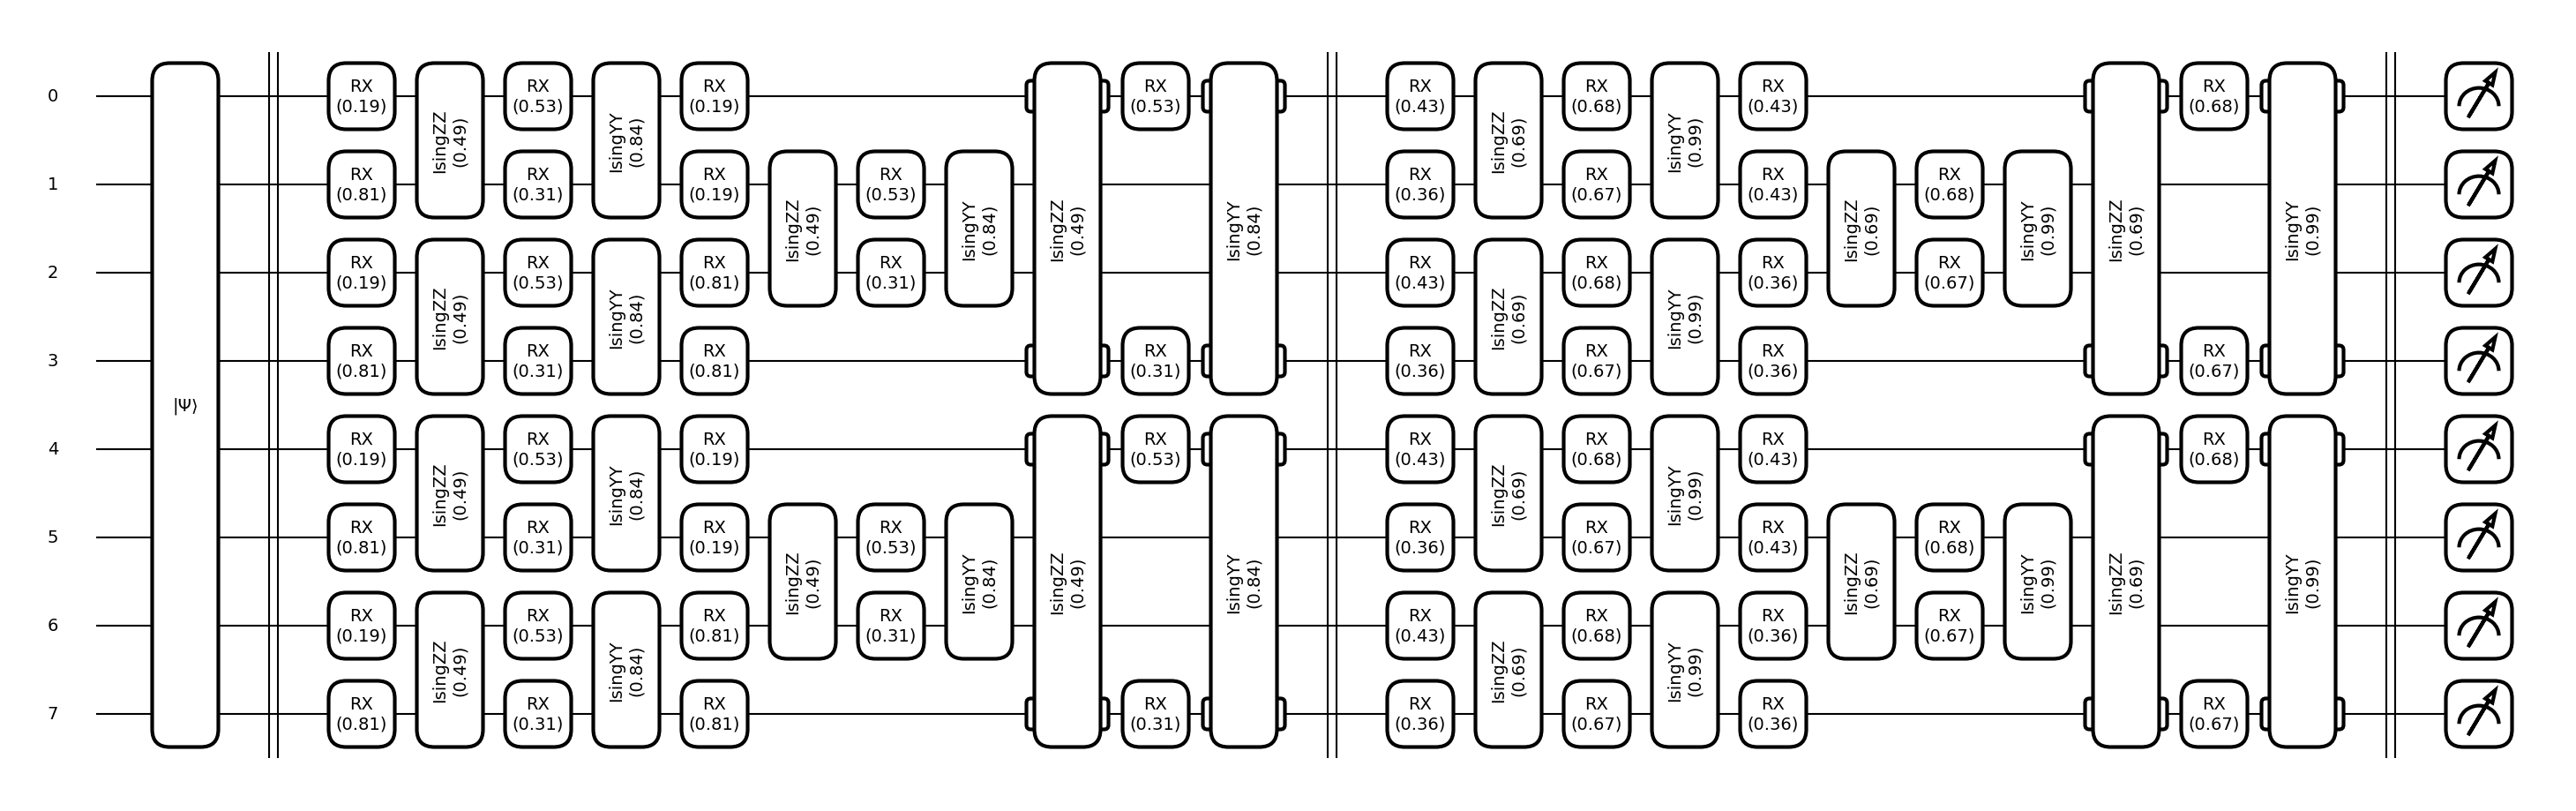

In [9]:
n = 8
L = 2
dev = qml.device("default.qubit", wires=n)

@qml.qnode(dev)
def REQNN(x, params, wires= range(n), n_layers=2):
    # Amplitude Embedding
    embed_image(x, wires)

    # Apply the trainable block for the specified number of layers
    for layer in range(n_layers):
        #layer_params = params[6*layer:6*(layer+1)]
        qml.Barrier(wires=wires)
        for i in range(int(len(wires) / 2)):
            U2(params[6*layer:6*(layer+1)], [wires[2 * i], wires[2 * i + 1]])
        U2(params[6*layer:6*(layer+1)], [wires[1], wires[2]])
        U2(params[6*layer:6*(layer+1)], [wires[5], wires[6]])
        U2(params[6*layer:6*(layer+1)], [wires[0], wires[3]])
        U2(params[6*layer:6*(layer+1)], [wires[4], wires[7]])
    qml.Barrier(wires=wires)
    # Measurement of all qubits with respect to the Z observable
    return qml.expval((qml.PauliZ(0)) @ qml.PauliZ(1) @ qml.PauliZ(2) @ qml.PauliZ(3) @ qml.PauliZ(4) @ qml.PauliZ(5) @ qml.PauliZ(6) @ qml.PauliZ(7))
    #return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]


x_original = np.arange(2**n).reshape(16,16,1)
params = np.random.rand((6) * L, requires_grad = True)
wires = [i for i in range(n)]

print(REQNN(x_original, params, n_layers = L))
qml.draw_mpl(REQNN, decimals=2)(x_original, params, n_layers= L)

## MNIST dataset

In [10]:
!unzip datasets_hd5.zip

Archive:  datasets_hd5.zip
  inflating: Electron-Photon-bilinear-tracker-(16, 16, 1).h5  
  inflating: QG-bilinear-tracker-(16, 16, 1).h5  


In [11]:
import h5py
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torchvision import transforms

path_ep = "/content/QG-bilinear-tracker-(16, 16, 1).h5"
with h5py.File(path_ep, "r") as file:
    X_ep = np.array(file["X"])
    y_ep = np.array(file["y"])

X_train, X_test, Y_train, Y_test = train_test_split(X_ep, y_ep, test_size=0.2, random_state=42, stratify=y_ep)


print(X_train.shape)
print(X_test.shape)

(160000, 16, 16, 1)
(40000, 16, 16, 1)


## INVARIANCE EXAMPLE

/usr/local/lib/python3.10/dist-packages/pennylane/math/utils.py:228: UserWarning: Contains tensors of types {'autograd', 'jax'}; dispatch will prioritize TensorFlow, PyTorch, and Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pennylane/math/utils.py:228: UserWarning: Contains tensors of types {'autograd', 'jax'}; dispatch will prioritize TensorFlow, PyTorch, and Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pennylane/math/utils.py:228: UserWarning: Contains tensors of types {'autograd', 'jax'}; dispatch will prioritize TensorFlow, PyTorch, and Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pennylane/math/utils.py:228: UserWarning: Contains tensors of types {'autograd', 'jax'}; dispatch will prioritize TensorFlow, PyTorch, and Jax over Autograd. Consider repl

 Output with Probabilities for Original Image: 0.09594383090734482
 Output with Probabilities for Image Reflected over Y-axis: 0.09594383835792542


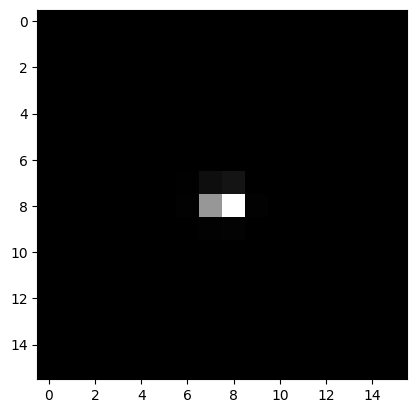

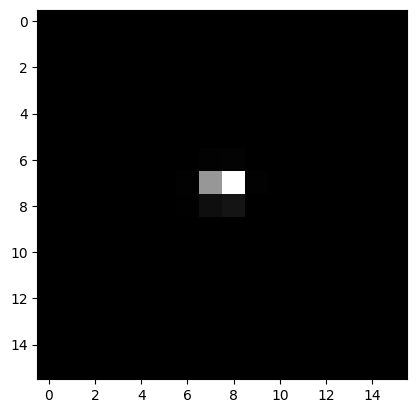

In [12]:
matrix = jnp.array(X_train[0])

# Image Reflected over Y-axis
matrix_reflected_y = np.fliplr(matrix)

# Image Reflected over X-axis
matrix_reflected_x = np.flipud(matrix)

# Image rotated 90 degrees
matrix_rotated_90 = np.rot90(matrix)

# array to JAX
matrix_reflected_x_jax = jnp.array(matrix_reflected_x)

result1 = REQNN(matrix, params)
result2 = REQNN(matrix_reflected_x_jax, params)


print(f" Output with Probabilities for Original Image: {result1}")
print(f" Output with Probabilities for Image Reflected over Y-axis: {result2}")


plt.imshow(matrix, cmap='gray')
plt.show()
plt.imshow(matrix_reflected_x, cmap='gray')
plt.show()


## Training

In [13]:
L = 2
params = jnp.ones(6*L)


jitcircuit = jax.jit(REQNN)
vcircuit = jax.vmap(jitcircuit, (None, 0), 0)

In [14]:
# data = jnp.array(np.random.rand(16,16,1))

# map_loss(params, jnp.array([data, data*2]))

In [15]:
# Generates minibatches only for X
def iterate_minibatches(data, batch_size):
    for start_idx in range(0, data.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield data[idxs]

In [16]:
learning_rate = 0.01
epochs = 10
batch_size = 50

In [17]:
optimizer = optax.adam(learning_rate)

In [18]:
weight_shapes = {"weights": (6*L,)}
key1 = jax.random.PRNGKey(0)
params = jax.random.uniform(key=key1, shape=weight_shapes["weights"])

In [19]:
opt_state = optimizer.init(params)

In [20]:
def map_loss(params, xbatch, ybatch):
    loss = 0
    for i, x in enumerate(xbatch):
        f = jitcircuit(x, params)
        loss += (ybatch[i] - f) ** 2
    return loss / len(xbatch)

# generate minibatches for X and Y
def iterate_minibatches(inputs, targets, batch_size):
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

# Define accuracy function
def accuracy(labels, predictions):
    # Convert predictions to binary 0 or 1
    binary_predictions = [1 if p >= 0.5 else 0 for p in predictions]
    correct_predictions = sum(l == p for l, p in zip(labels, binary_predictions))
    acc = correct_predictions / len(labels)
    return acc

In [21]:
import time
import csv
import jax
import optax
import jax.numpy as jnp

n_train = 500
n_test = 100

L = 2
batch_size = 50
learning_rate = 0.01
epochs = 50

weight_shapes = {"weights": (6*L,)}
key1 = jax.random.PRNGKey(0)
params = jax.random.uniform(key=key1, shape=weight_shapes["weights"])
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

# Training and evaluation loop
start = time.time()

hist_loss = []
hist_val_loss = []
train_accuracy = []
test_accuracy = []

for it in range(epochs):
    start_b = time.time()
    for Xbatch, ybatch in iterate_minibatches(X_train[:n_train], Y_train[:n_train], batch_size=batch_size):
        grads = jax.grad(map_loss)(params, Xbatch, ybatch)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)

    loss = map_loss(params, X_train[:int(n_train/5)], Y_train[:int(n_train/5)])
    hist_loss.append(loss)
    val_loss = map_loss(params, X_test[:n_test], Y_test[:n_test])
    hist_val_loss.append(val_loss)

    # Calculate training and validation accuracy
    train_predictions = [jitcircuit(x, params) for x in X_train[:int(n_train/5)]]
    train_acc = accuracy(Y_train[:int(n_train/5)], train_predictions)
    train_accuracy.append(train_acc)

    test_predictions = [jitcircuit(x, params) for x in X_test[:n_test]]
    val_acc = accuracy(Y_test[:n_test], test_predictions)

    test_accuracy.append(val_acc)
    print("____")
    print(f"Epoch: {it} | Loss: {loss:.3f} | Val Loss: {val_loss:.3f} | Train Accuracy: {train_acc:.3f} | Val Accuracy: {val_acc:.3f}")
    print("____")

val_loss_final = map_loss(params, X_test[:n_test], Y_test[:n_test])
print("Final validation loss:", val_loss_final)

end = time.time()

training_time = end - start
print(f"Time for {epochs} epochs: {training_time}")

# Calculate final accuracies
final_train_accuracy = train_accuracy[-1]
final_test_accuracy = test_accuracy[-1]

# Calculate inference time
inference_start = time.time()
_ = [jitcircuit(x, params) for x in X_test[:n_test]]
inference_end = time.time()
inference_time = inference_end - inference_start

# Prepare metrics for CSV
metrics = {
    'Optimizer': optimizer.__class__.__name__,
    'Learning_Rate': learning_rate,
    'Batch_Size': batch_size,
    'Epochs': epochs,
    'Loss_Function': 'map_loss',  # Assuming this is the name of your loss function
    'Training_Subset_Size': f"{n_train} (full dataset)",
    'Training_Time': f"{training_time:.2f}",
    'Inference_Time': f"{inference_time:.2f}",
    'Final_Train_Accuracy': f"{final_train_accuracy:.2f}",
    'Final_Test_Accuracy': f"{final_test_accuracy:.2f}"
}

# Write metrics to CSV
csv_filename = 'REFLECTION_EQCNN_Quark_Gluon_metrics.csv'
with open(csv_filename, 'w', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=metrics.keys())
    writer.writeheader()
    writer.writerow(metrics)

print(f"Metrics have been saved to {csv_filename}")

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array

____
Epoch: 0 | Loss: 0.364 | Val Loss: 0.352 | Train Accuracy: 0.470 | Val Accuracy: 0.490
____
____
Epoch: 1 | Loss: 0.258 | Val Loss: 0.263 | Train Accuracy: 0.530 | Val Accuracy: 0.510
____
____
Epoch: 2 | Loss: 0.253 | Val Loss: 0.252 | Train Accuracy: 0.470 | Val Accuracy: 0.490
____
____
Epoch: 3 | Loss: 0.249 | Val Loss: 0.251 | Train Accuracy: 0.530 | Val Accuracy: 0.510
____
____
Epoch: 4 | Loss: 0.249 | Val Loss: 0.250 | Train Accuracy: 0.530 | Val Accuracy: 0.510
____
____
Epoch: 5 | Loss: 0.249 | Val Loss: 0.250 | Train Accuracy: 0.530 | Val Accuracy: 0.510
____
____
Epoch: 6 | Loss: 0.249 | Val Loss: 0.250 | Train Accuracy: 0.530 | Val Accuracy: 0.510
____
____
Epoch: 7 | Loss: 0.249 | Val Loss: 0.249 | Train Accuracy: 0.530 | Val Accuracy: 0.510
____
____
Epoch: 8 | Loss: 0.249 | Val Loss: 0.250 | Train Accuracy: 0.530 | Val Accuracy: 0.510
____
____
Epoch: 9 | Loss: 0.249 | Val Loss: 0.250 | Train Accuracy: 0.530 | Val Accuracy: 0.510
____
____
Epoch: 10 | Loss: 0.249 |

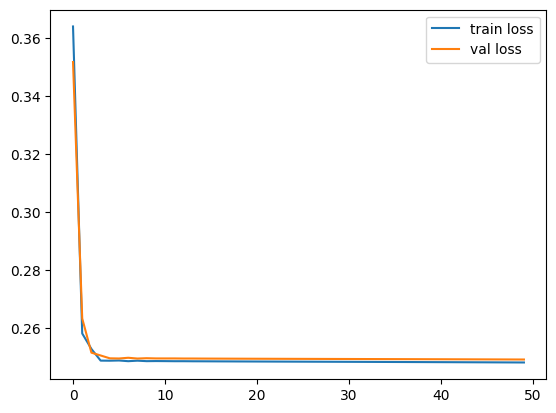

In [22]:
plt.plot(hist_loss, label = "train loss")
plt.plot(hist_val_loss, label = "val loss")
plt.legend()

plt.show()

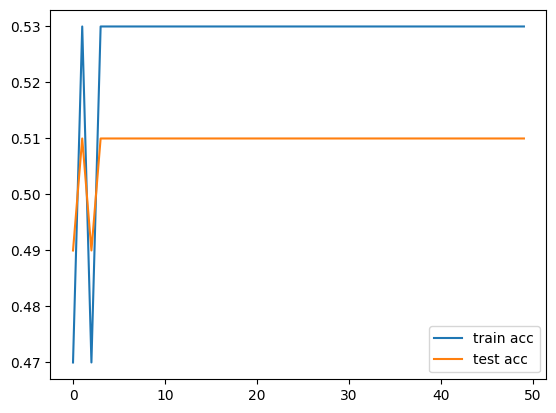

In [23]:
plt.plot(train_accuracy, label = "train acc")
plt.plot(test_accuracy, label = "test acc")
plt.legend()

plt.show()